# One-dim experiments

In [1]:
import sys
sys.path.append("/home/lauro/code/msc-thesis/svgd")

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp

import utils
import metrics
import time
import plot
from svgd import SVGD

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# dist = metrics.Gaussian(0, 1)
# dist = metrics.GaussianMixture([-3, 3], [1, 1], [1/3, 2/3])
dist = metrics.Gaussian(0, 6)

n = 100
d = dist.d

n_steps = 1000
svgd = SVGD(dist, n_steps, particle_shape=(n, d), adagrad=False)

In [3]:
h = 1000
lr = 500
svgd_stepsize = 1
bandwidth = np.log(h)
print(bandwidth)

6.9077554


In [4]:
np.log(56)

DeviceArray(4.0253515, dtype=float32)

In [5]:
rkey = random.split(rkey)[0]

### train

In [6]:
st = time.time()
x, log, = svgd.train(rkey, bandwidth, lr, svgd_stepsize, n_steps)
x.block_until_ready()
end = time.time()
print(f"took {end - st} seconds")
print(log["desc"]["bandwidth"][-4:][:, 0])
learned_h = log["desc"]["bandwidth"][-1]

100%|██████████| 1000/1000 [00:18<00:00, 55.40it/s]


took 18.582239627838135 seconds
[0.10442306 0.10184483 0.09933027 0.09687778]


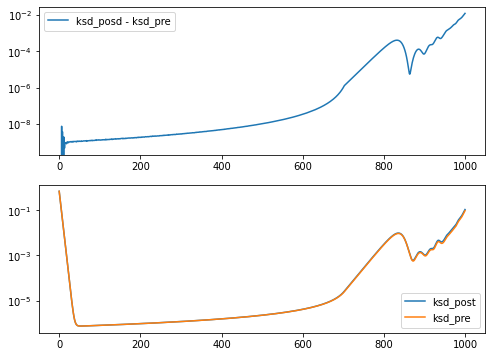

In [7]:
fig, axs = plt.subplots(2,1, figsize=[8, 6])
names = ["ksd_post", "ksd_pre"]
ax = axs[0]
ax.plot(log[names[0]] - log[names[1]], label="ksd_posd - ksd_pre")
ax.set_yscale("log")
ax.legend()

ax = axs[1]
for key in names:
    lines = ax.plot(log[key], label=key)
    ax.set_yscale("log")
    ax.legend()

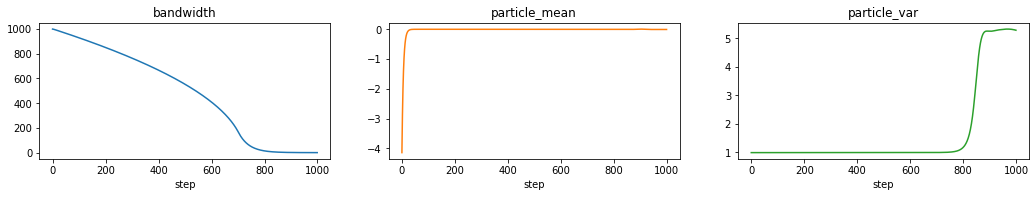

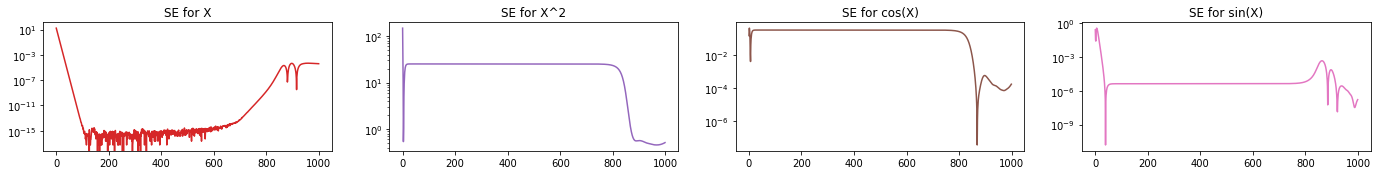

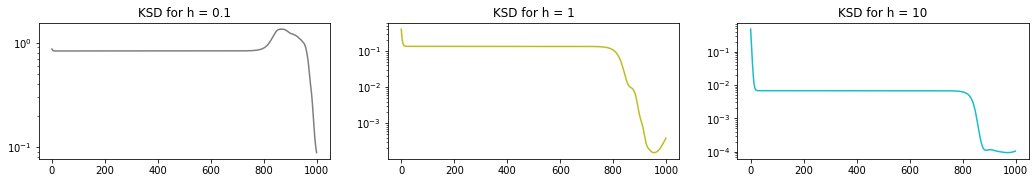

In [8]:
plot.svgd_log(log, full=True)

In [9]:
st = time.time()
x0 = svgd.initialize(rkey)
xs, logs = svgd.svgd(x0, svgd_stepsize, bandwidth, n_steps)
end = time.time()
print(f"took {end - st} seconds")

JIT COMPILING svgd...
...done compiling svgd after 0.8683984279632568 seconds.
took 8.178250551223755 seconds


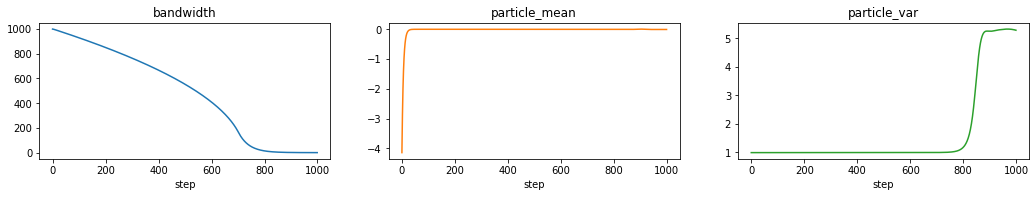

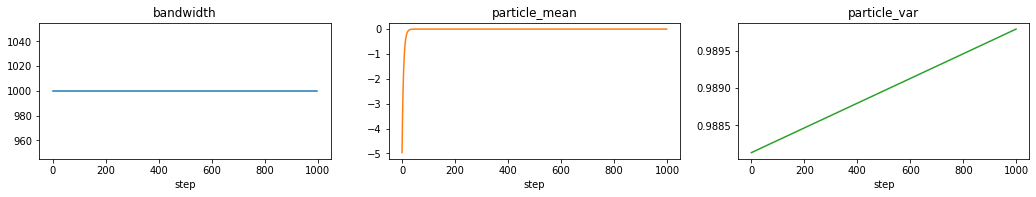

In [10]:
plot.svgd_log(log)#, full=True)
plot.svgd_log(logs)

# Histograms

In [11]:
learned_bandwidth = np.log(learned_h)
x0 = svgd.initialize(rkey)
xsl, logsl = svgd.svgd(x0, svgd_stepsize, learned_bandwidth, n_steps)
end = time.time()
print(f"took {end - st} seconds")

JIT COMPILING svgd...
...done compiling svgd after 0.3260498046875 seconds.
took 13.042497873306274 seconds


In [12]:
s = dist.sample(shape=(n,1))

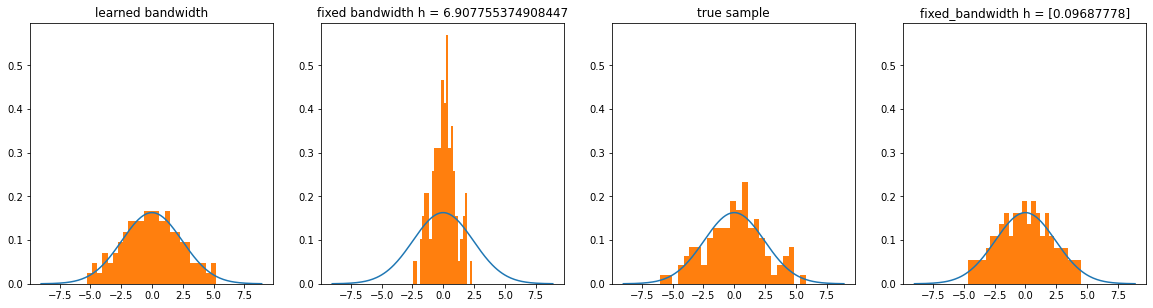

In [17]:
grid = np.arange(-9, 9, 0.1)

fig, axs = plt.subplots(1, 4, figsize = [20, 4.8])
for ax, out, title in zip(axs, (x, xs, s, xsl), ("learned bandwidth", f"fixed bandwidth h = {h}", "true sample", f"fixed_bandwidth h = {learned_h}")):
    _ = ax.plot(grid, vmap(dist.pdf)(grid))
    _ = ax.hist(out[:, 0], density=True, bins=25)
    _ = ax.set_title(title)

_ = plot.equalize_axes(axs)

In [14]:
print("svgd_h = ", bandwidth)
print("--------------")
for h in (1, 100, 1000):
    h = np.log(h)
    print("h = ", h)
    print(metrics.ksd_squared(xs, dist.logpdf, h))
    print()

svgd_h =  6.9077554
--------------
h =  0.0
0.135677

h =  4.6051702
6.97073e-05

h =  6.9077554
6.972736e-07



# 1d scatterplot

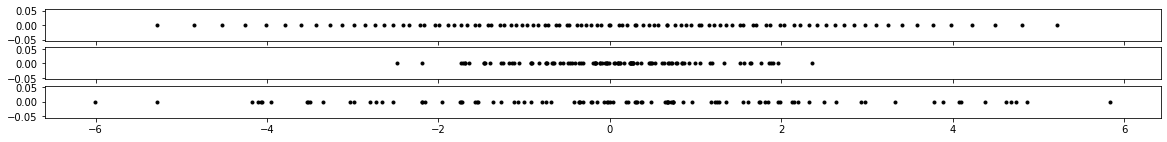

In [15]:
figs, axs = plt.subplots(3, figsize=[20, 2])
# figs.tight_layout = True

titles = ["Learned", "Fixed", "True random"]
samples = [x[:, 0], xs[:, 0], s]
mins = []
maxs = []

for ax, t, sam in zip(axs, titles, samples):
    ax.plot(sam, np.zeros(n), "k.")
#     ax.set_title(t)
    lims = ax.get_xlim()
    mins.append(lims[0])
    maxs.append(lims[1])

lims = [min(mins), max(maxs)]
for ax in axs:
    ax.set_xlim(lims)